In [28]:
# ==========================
# Cell 1: Imports & Data Load
# ==========================
import os
import pandas as pd
import numpy as np

import requests
import json
import logging
import time

from typing import List, Dict, Any, Optional
from enum import Enum
from dataclasses import dataclass

from sklearn.metrics import cohen_kappa_score, confusion_matrix

# Define the output directory
output_dir = '03_data_ai'
# os.makedirs(output_dir, exist_ok=True)

# Read the parquet file
df_stats = pd.read_parquet(f'../{output_dir}/part_3_covariates_final.parquet')

print("DataFrame loaded. Shape:", df_stats.shape)
df_stats.head(3)

DataFrame loaded. Shape: (64, 68)


,Index,NCTId,LeadSponsorClass,LeadSponsorName,Condition,OfficialTitle,BriefTitle,Acronym,StudyType,InterventionType,...,relevant_quotes_anthropic_claude_3.5_sonnet,brain_stimulation_used_meta_llama_llama_3_70b_instruct,stimulation_details_primary_type_meta_llama_llama_3_70b_instruct,stimulation_details_is_noninvasive_meta_llama_llama_3_70b_instruct,stimulation_details_primary_target_meta_llama_llama_3_70b_instruct,stimulation_details_secondary_targets_meta_llama_llama_3_70b_instruct,stimulation_details_parameters_intensity_meta_llama_llama_3_70b_instruct,stimulation_details_parameters_duration_meta_llama_llama_3_70b_instruct,confidence_level_meta_llama_llama_3_70b_instruct,relevant_quotes_meta_llama_llama_3_70b_instruct
0,None,NCT06145776,OTHER,Federal University of Paraíba,"Parkinson Disease, Cognition Disorder, EEG Wit...",Effects of Cognitive-motor Dual-Task Training ...,The Role of EEG in Identifying Cognitive Chang...,,INTERVENTIONAL,",",...,"[""It is possible that strategies such as Trans...",Yes,tDCS,True,,[],,,High,"[""Transcranial Direct Current Stimulation can ..."
1,None,NCT04174573,OTHER,Maharishi Markendeswar University (Deemed to b...,Parkinson Disease,Efficacy of Group Therapy With Transcranial Di...,Group Therapy With Transcranial Direct Current...,GTBQ-PD,INTERVENTIONAL,",",...,"[""Transcranial direct current stimulation (tDC...",Yes,tDCS,True,Primary motor cortex M1,[],,20 minutes,High,"[""Anodal tDCS can increase M1 excitability, re..."
2,None,NCT03191916,OTHER,Sanford Health,Parkinson Disease,Transcranial Direct Current Stimulation (tDCS)...,Transcranial Direct Current Stimulation for Co...,tDCS,INTERVENTIONAL,",",...,"[""Transcranial direct current stimulation (tDC...",Yes,tDCS,True,LDLPFC,[],2 milliamps (mA),20 minutes,High,"[""During tDCS, low-voltage, low amplitude curr..."


In [29]:
# ==========================
# Cell 2: Parse Intensity & Duration
# ==========================

import re

# Columns to parse (GPT-4 as example; adapt for Claude or Llama if needed)
col_intensity_gpt4 = "stimulation_details_parameters_intensity_gpt_4"
col_duration_gpt4  = "stimulation_details_parameters_duration_gpt_4"

def parse_intensity(text_value: str) -> float:
    """
    Extracts a single numeric intensity from strings like "2mA", "1.5 mA", or "2mA and 4mA".
    Currently returns the first match or NaN if none found.
    """
    if pd.isna(text_value):
        return np.nan
    
    # Convert to lowercase string
    txt = str(text_value).lower()
    
    # Example: "2mA and 4mA" -> find the FIRST numeric => 2
    match = re.search(r"(\d+(\.\d+)?)", txt)
    if match:
        return float(match.group(1))
    return np.nan

def parse_duration(text_value: str) -> float:
    """
    Extract a numeric duration in minutes from strings like "20 minutes" or "5 days".
    Returns np.nan if parsing fails or if it's something like "Single session".
    
    Example conversions:
      - "20 minutes" -> 20
      - "5 days" -> 5 * 1440 = 7200
      - "Single session" -> np.nan (or handle differently if desired)
    """
    if pd.isna(text_value):
        return np.nan
    
    txt = str(text_value).lower()
    
    # Check if it's in minutes
    if "minute" in txt:
        match = re.search(r"(\d+(\.\d+)?)", txt)
        if match:
            return float(match.group(1))
        else:
            return np.nan
    
    # Check if it's in days
    if "day" in txt:
        match = re.search(r"(\d+(\.\d+)?)", txt)
        if match:
            # 1 day = 1440 min
            return float(match.group(1)) * 1440
        else:
            return np.nan
    
    # If "Single session" or something else you want to handle, do so
    # For now, we'll just return NaN
    return np.nan


# Create new numeric columns
df_stats["intensity_numeric_gpt4"] = df_stats[col_intensity_gpt4].apply(parse_intensity)
df_stats["duration_numeric_gpt4"]  = df_stats[col_duration_gpt4].apply(parse_duration)

# Show some rows
df_stats[[col_intensity_gpt4, "intensity_numeric_gpt4",
          col_duration_gpt4, "duration_numeric_gpt4"]].head(10)

,stimulation_details_parameters_intensity_gpt_4,intensity_numeric_gpt4,stimulation_details_parameters_duration_gpt_4,duration_numeric_gpt4
0,,NaN,,NaN
1,,NaN,20 minutes,20.0
2,2mA,2.0,20 minutes,20.0
3,1.5 mA,1.5,20 minutes,20.0
4,,NaN,,NaN
5,2mA and 4mA,2.0,25 minutes,25.0
6,,NaN,5 days,7200.0
7,,NaN,46 minutes,46.0
8,,NaN,Single session,NaN
9,,NaN,,NaN


In [30]:
# ==========================
# Cell 3: Basic Analysis
# ==========================

# 1) Count how many rows have valid intensities/durations
valid_intensity = df_stats["intensity_numeric_gpt4"].notna().sum()
valid_duration  = df_stats["duration_numeric_gpt4"].notna().sum()

print("Rows with valid GPT-4 intensity:", valid_intensity)
print("Rows with valid GPT-4 duration:", valid_duration)

# 2) Mean & standard deviation (if numeric)
mean_intensity = df_stats["intensity_numeric_gpt4"].mean(skipna=True)
std_intensity  = df_stats["intensity_numeric_gpt4"].std(skipna=True)

mean_duration  = df_stats["duration_numeric_gpt4"].mean(skipna=True)
std_duration   = df_stats["duration_numeric_gpt4"].std(skipna=True)

print(f"\nIntensity (mean ± std): {mean_intensity:.2f} ± {std_intensity:.2f} mA")
print(f"Duration (mean ± std): {mean_duration:.2f} ± {std_duration:.2f} minutes")

# 3) Correlation (just an example)
corr = df_stats["intensity_numeric_gpt4"].corr(df_stats["duration_numeric_gpt4"])
print(f"\nCorrelation between intensity and duration: {corr:.3f}")

Rows with valid GPT-4 intensity: 10
Rows with valid GPT-4 duration: 20

Intensity (mean ± std): 1.65 ± 0.47 mA
Duration (mean ± std): 740.45 ± 2209.13 minutes

Correlation between intensity and duration: 0.849


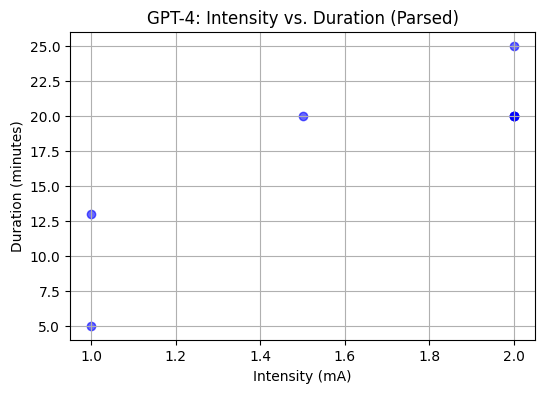

In [31]:
# ==========================
# Cell 4: Quick Plot
# ==========================
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

plt.scatter(
    df_stats["intensity_numeric_gpt4"], 
    df_stats["duration_numeric_gpt4"], 
    alpha=0.6, 
    c="blue"
)
plt.xlabel("Intensity (mA)")
plt.ylabel("Duration (minutes)")
plt.title("GPT-4: Intensity vs. Duration (Parsed)")
plt.grid(True)
plt.show()

In [32]:
# # Cell 5: Example Output or Plot

# import matplotlib.pyplot as plt

# plt.figure(figsize=(6,4))
# plt.scatter(df["intensity_numeric"], df["duration_numeric"], alpha=0.6)
# plt.xlabel("Intensity (mA)")
# plt.ylabel("Duration (minutes)")
# plt.title("GPT-4: Intensity vs Duration (Parsed)")
# plt.grid(True)
# plt.show()

redo


In [33]:
# Suppose you have functions parse_intensity() and parse_duration() already.

df_stats["intensity_numeric_gpt4"] = df_stats["stimulation_details_parameters_intensity_gpt_4"].apply(parse_intensity)
df_stats["intensity_numeric_claude"] = df_stats["stimulation_details_parameters_intensity_anthropic_claude_3.5_sonnet"].apply(parse_intensity)
df_stats["intensity_numeric_llama"] = df_stats["stimulation_details_parameters_intensity_meta_llama_llama_3_70b_instruct"].apply(parse_intensity)

df_stats["duration_numeric_gpt4"] = df_stats["stimulation_details_parameters_duration_gpt_4"].apply(parse_duration)
df_stats["duration_numeric_claude"] = df_stats["stimulation_details_parameters_duration_anthropic_claude_3.5_sonnet"].apply(parse_duration)
df_stats["duration_numeric_llama"] = df_stats["stimulation_details_parameters_duration_meta_llama_llama_3_70b_instruct"].apply(parse_duration)

In [34]:
# ===============================
# Cell 1: Imports and Data Loading
# ===============================
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import pingouin as pg  # For intraclass correlation (ICC)

# Assume df_stats is already loaded and has numeric columns
# e.g. "intensity_numeric_gpt4", "intensity_numeric_claude", "intensity_numeric_llama"
#      "duration_numeric_gpt4",  "duration_numeric_claude",  "duration_numeric_llama"

# ===============================
# Cell 2: Pairwise Stats (MAE, Correlation)
# ===============================

# Example for INTENSITY
pairs_intensity = [
    ("intensity_numeric_gpt4", "intensity_numeric_claude", "GPT-4 vs Claude"),
    ("intensity_numeric_gpt4", "intensity_numeric_llama",  "GPT-4 vs Llama"),
    ("intensity_numeric_claude", "intensity_numeric_llama", "Claude vs Llama")
]

results_list_int = []

for col_a, col_b, label in pairs_intensity:
    temp_df = df_stats.dropna(subset=[col_a, col_b])
    if temp_df.empty:
        mae, corr = np.nan, np.nan
    else:
        mae = mean_absolute_error(temp_df[col_a], temp_df[col_b])
        corr = temp_df[col_a].corr(temp_df[col_b])
    
    # Round each metric to 2 decimals
    results_list_int.append({
        "Comparison": label,
        "MAE": round(mae, 2),
        "Correlation": round(corr, 2)
    })

df_compare_intensity = pd.DataFrame(results_list_int)
print("=== Pairwise Comparison: Intensity ===")
print(df_compare_intensity)

# Example for DURATION
pairs_duration = [
    ("duration_numeric_gpt4", "duration_numeric_claude", "GPT-4 vs Claude"),
    ("duration_numeric_gpt4", "duration_numeric_llama",  "GPT-4 vs Llama"),
    ("duration_numeric_claude", "duration_numeric_llama","Claude vs Llama")
]

results_list_dur = []

for col_a, col_b, label in pairs_duration:
    temp_df = df_stats.dropna(subset=[col_a, col_b])
    if temp_df.empty:
        mae, corr = np.nan, np.nan
    else:
        mae = mean_absolute_error(temp_df[col_a], temp_df[col_b])
        corr = temp_df[col_a].corr(temp_df[col_b])
    
    results_list_dur.append({
        "Comparison": label,
        "MAE": round(mae, 2),
        "Correlation": round(corr, 2)
    })

df_compare_duration = pd.DataFrame(results_list_dur)
print("\n=== Pairwise Comparison: Duration ===")
print(df_compare_duration)

# ===============================
# Cell 3: Intraclass Correlation (ICC)
# ===============================

# INTENSITY
df_icc_int = df_stats[["intensity_numeric_gpt4",
                       "intensity_numeric_claude",
                       "intensity_numeric_llama"]].dropna().reset_index()

df_icc_int = df_icc_int.rename(columns={"index": "TrialID"})
df_icc_int_melt = df_icc_int.melt(
    id_vars="TrialID",
    var_name="Rater",
    value_name="Score"
)

icc_intensity = pg.intraclass_corr(
    data=df_icc_int_melt,
    targets="TrialID",
    raters="Rater",
    ratings="Score"
)

# Option: round all columns to 2 decimals after ICC
icc_intensity_rounded = icc_intensity.round(2)

print("\n=== Intraclass Correlation: Intensity ===")
print(icc_intensity_rounded)

# DURATION
df_icc_dur = df_stats[["duration_numeric_gpt4",
                       "duration_numeric_claude",
                       "duration_numeric_llama"]].dropna().reset_index()

df_icc_dur = df_icc_dur.rename(columns={"index": "TrialID"})
df_icc_dur_melt = df_icc_dur.melt(
    id_vars="TrialID",
    var_name="Rater",
    value_name="Score"
)

icc_duration = pg.intraclass_corr(
    data=df_icc_dur_melt,
    targets="TrialID",
    raters="Rater",
    ratings="Score"
)

icc_duration_rounded = icc_duration.round(2)

print("\n=== Intraclass Correlation: Duration ===")
print(icc_duration_rounded)

=== Pairwise Comparison: Intensity ===
        Comparison  MAE  Correlation
0  GPT-4 vs Claude  0.0          1.0
1   GPT-4 vs Llama  0.0          1.0
2  Claude vs Llama  0.0          1.0

=== Pairwise Comparison: Duration ===
        Comparison      MAE  Correlation
0  GPT-4 vs Claude  1137.00         0.35
1   GPT-4 vs Llama     0.00         1.00
2  Claude vs Llama  1200.17         0.35

=== Intraclass Correlation: Intensity ===
    Type              Description  ICC             F  df1  df2  pval  \
0   ICC1   Single raters absolute  1.0 -7.599824e+15    9   20   1.0   
1   ICC2     Single random raters  1.0 -6.839842e+15    9   18   1.0   
2   ICC3      Single fixed raters  1.0 -6.839842e+15    9   18   1.0   
3  ICC1k  Average raters absolute  1.0 -7.599824e+15    9   20   1.0   
4  ICC2k    Average random raters  1.0 -6.839842e+15    9   18   1.0   
5  ICC3k     Average fixed raters  1.0 -6.839842e+15    9   18   1.0   

        CI95%  
0  [1.0, 1.0]  
1  [1.0, 1.0]  
2  [1.0, 1.0] 

/opt/homebrew/Caskroom/miniconda/base/envs/PD_research/lib/python3.12/site-packages/pingouin/parametric.py:1008: RuntimeWarning: divide by zero encountered in scalar divide
  fval = msbetween / mserror


In [35]:
# # Cell 5 (Example): Scatter Plot with Times New Roman

# import matplotlib.pyplot as plt
# import matplotlib as mpl

# # Ensure all fonts default to Times New Roman
# mpl.rcParams["font.family"] = "Times New Roman"

# # Suppose you have 'df' with columns "intensity_numeric" and "duration_numeric"
# plt.figure(figsize=(6,4))
# plt.scatter(df["intensity_numeric"], df["duration_numeric"], alpha=0.6, c="blue")
# plt.xlabel("Intensity (mA)", fontsize=12)
# plt.ylabel("Duration (minutes)", fontsize=12)
# plt.title("GPT-4: Intensity vs Duration (Parsed)", fontsize=14)
# plt.grid(True)
# plt.show()

In [36]:
# =====================================
# Cell: Generate & Export Tables via dataframe_image
# =====================================
import pandas as pd
import dataframe_image as dfi

# Suppose you already have DataFrames:
#   df_compare_intensity, df_compare_duration (pairwise results)
#   icc_intensity, icc_duration (ICC results)

# --- Function to format as 3 decimal places (e.g., 0.354 or 0.350) ---
def three_decimals(x):
    if pd.isnull(x):
        return ""
    return f"{x:.3f}"  # always 3 decimals, no scientific notation for typical ranges

# 1A) Build Table 2: Pairwise Comparisons
df_table2 = pd.DataFrame({
    "Comparison": df_compare_intensity["Comparison"],
    "MAE(Intensity)": df_compare_intensity["MAE"].apply(three_decimals),
    "Corr(Intensity)": df_compare_intensity["Correlation"].apply(three_decimals),
    "MAE(Duration)": df_compare_duration["MAE"].apply(three_decimals),
    "Corr(Duration)": df_compare_duration["Correlation"].apply(three_decimals)
})

print("\n===== Table 2: Pairwise Comparisons (Intensity & Duration) =====")
print(df_table2)


# 1B) Build Table 3: ICC
def extract_icc_2_1(icc_df):
    """
    pingouin.intraclass_corr returns columns: ["Type", "Description", "ICC", ...].
    We'll pick the row with Type == "ICC2" (Single random raters, i.e., ICC(2,1)).
    """
    row = icc_df[icc_df["Type"] == "ICC2"].iloc[0]
    return {
        "Type": "ICC(2,1)",
        "ICC": row["ICC"],
        "CI95%": row["CI95%"],
        "pval": row["pval"],
        "Description": row["Description"]
    }

icc_int_2_1 = extract_icc_2_1(icc_intensity)
icc_dur_2_1 = extract_icc_2_1(icc_duration)

# Keep ICC table at 3 decimal places
df_table3 = pd.DataFrame([
    {
        "Measure": "Intensity",
        "ICC(2,1)": f"{icc_int_2_1['ICC']:.3f}",
        "95% CI": icc_int_2_1["CI95%"],
        "p-value": f"{icc_int_2_1['pval']:.3f}",
        "Interpretation": icc_int_2_1["Description"]
    },
    {
        "Measure": "Duration",
        "ICC(2,1)": f"{icc_dur_2_1['ICC']:.3f}",
        "95% CI": icc_dur_2_1["CI95%"],
        "p-value": f"{icc_dur_2_1['pval']:.3f}",
        "Interpretation": icc_dur_2_1["Description"]
    }
])

print("\n===== Table 3: Intraclass Correlation (ICC) =====")
print(df_table3)


# 2) Style & export each table (Times New Roman, via dataframe_image)
def style_and_export_table(df, filename, title=None):
    """
    Renders `df` as a PNG with dataframe_image, including a caption (table label).
    Ensures Times New Roman for the entire table.
    """
    df_no_index = df.reset_index(drop=True)

    df_style = (
        df_no_index.style
        .set_caption(title if title else "")
        .set_properties(**{
            "text-align": "center",
            "font-family": "Times New Roman",
            "font-size": "12px"
        })
        .set_table_styles([
            dict(selector="caption",
                 props=[("caption-side", "top"),
                        ("font-weight", "bold"),
                        ("font-size", "14px"),
                        ("font-family", "Times New Roman")]),
            dict(selector="thead th",
                 props=[
                     ("border", "1px solid black"),
                     ("background-color", "#f2f2f2"),
                     ("font-family", "Times New Roman"),
                     ("font-size", "12px")
                 ]),
            dict(selector="tbody td",
                 props=[("border", "1px solid black")]),
            dict(selector=".row_heading, .blank",
                 props=[("display", "none")])
        ])
    )

    dfi.export(df_style, filename, dpi=300, max_rows=None, max_cols=None)
    print(f"Saved table to {filename} with title: {title}")


# 2A) Export Table 2
style_and_export_table(
    df_table2,
    filename="table2_pairwise_comparisons.png",
    title="Table 2: Pairwise Comparisons"
)

# 2B) Export Table 3
style_and_export_table(
    df_table3,
    filename="table3_intraclass_correlation.png",
    title="Table 3: Intraclass Correlation"
)


===== Table 2: Pairwise Comparisons (Intensity & Duration) =====
        Comparison MAE(Intensity) Corr(Intensity) MAE(Duration) Corr(Duration)
0  GPT-4 vs Claude              0               1      1.14e+03           0.35
1   GPT-4 vs Llama              0               1             0              1
2  Claude vs Llama              0               1       1.2e+03           0.35

===== Table 3: Intraclass Correlation (ICC) =====
     Measure ICC(2,1)        95% CI p-value        Interpretation
0  Intensity    1.000    [1.0, 1.0]   1.000  Single random raters
1   Duration    0.354  [0.07, 0.65]   0.008  Single random raters
Saved table to table2_pairwise_comparisons.png with title: Table 2: Pairwise Comparisons
Saved table to table3_intraclass_correlation.png with title: Table 3: Intraclass Correlation
